<a href="https://colab.research.google.com/github/cl0udy322322-crypto/project3/blob/main/%EC%BD%94%EC%8A%A4%EB%8B%A5_150_%EC%A2%85%EB%AA%A9_%EC%95%8C%ED%8C%8C%EC%B0%BE%EA%B8%B0_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# 1. TA-Lib 설치 (소스 빌드 방식 - 약 1분 소요)
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install ta-lib
%cd /content

# 2. 필수 라이브러리 설치
!pip install -q finance-datareader pandas numpy matplotlib seaborn

# 3. 한글 폰트 설치 (설치 후 '런타임 다시 시작'을 해야 할 수도 있습니다)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import talib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

--2026-02-05 00:49:46--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2026-02-05 00:49:46--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://onboardcloud.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2026-02-05 00:49:46--  http://onboardcloud

In [40]:
# [STEP 1] 유니버스 로드
universe = pd.read_csv("코스닥 150종목(2025년 12월 30일자 기준).csv", encoding='euc-kr')

# 종목코드 6자리 문자열 처리
universe["종목코드"] = universe["종목코드"].astype(str).str.zfill(6)
tickers = universe["종목코드"].tolist()

print(f"✅ 코스닥 150 유니버스 로드 완료: {len(tickers)}개 종목")

✅ 코스닥 150 유니버스 로드 완료: 150개 종목


In [41]:
# [STEP 2] 가격 데이터 수집 (2016-01-01 ~ 2025-12-31)
START, END = "2016-01-01", "2025-12-31"
price_list = []

print("🚀 데이터 수집 시작 (전 종목 일봉)...")
for code in tickers:
    try:
        df = fdr.DataReader(code, START, END)
        if not df.empty:
            df["Ticker"] = code
            price_list.append(df)
    except:
        continue

price_df = pd.concat(price_list).reset_index()
price_df.set_index(["Date", "Ticker"], inplace=True)
price_df.sort_index(inplace=True)

# 기초 클렌징 (결측치 및 거래정지일 제거)
price_df = price_df[price_df["Close"].notna() & (price_df["Volume"] > 0)]
print(f"✅ 가격 데이터셋 구축 완료")

🚀 데이터 수집 시작 (전 종목 일봉)...
✅ 가격 데이터셋 구축 완료


In [42]:
# [STEP 3] 모든 팩터 생성 함수
def compute_all_indicators(group):
    c, h, l, v = group['Close'], group['High'], group['Low'], group['Volume']

    # --- MACD ---
    macd, signal, _ = talib.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)
    group['MACD'], group['MACD_signal'] = macd, signal

    # --- 1. Momentum Group (5) ---
    group['mom_1m'], group['mom_3m'] = c.pct_change(20), c.pct_change(60)
    group['mom_6m'], group['mom_12m'] = c.pct_change(120), c.pct_change(250)
    group['ret_5d'] = c.pct_change(5)

    # --- 2. Trend Group (5) ---
    group['ma_gap_20'], group['ma_gap_60'] = c/c.rolling(20).mean()-1, c/c.rolling(60).mean()-1
    group['ma_slope_20'] = c.rolling(20).mean().pct_change(5)
    group['ma_slope_60'] = c.rolling(60).mean().pct_change(5)
    group['price_z_60'] = (c - c.rolling(60).mean()) / c.rolling(60).std()

    # --- 3. Volatility Group (5) ---
    group['vol_1m'], group['vol_3m'] = c.pct_change().rolling(20).std(), c.pct_change().rolling(60).std()
    group['vol_6m'] = c.pct_change().rolling(120).std()
    group['range_20'] = (h.rolling(20).max() - l.rolling(20).min()) / c
    group['atr_20'] = talib.ATR(h, l, c, timeperiod=20) / c

    # --- 4. Volume Group (5) ---
    group['vol_z'] = (v - v.rolling(20).mean()) / v.rolling(20).std()
    group['vol_mom_20'] = v.pct_change(20)
    group['turnover_20'] = v / v.rolling(250).mean()
    dollar_vol = c * v
    group['dollar_vol_z'] = (dollar_vol - dollar_vol.rolling(20).mean()) / dollar_vol.rolling(20).std()
    group['volume_trend_20'] = v.rolling(20).mean() / v.rolling(60).mean()

    return group

print("📊 20개 팩터 및 MACD 계산 중...")
price_df = price_df.groupby('Ticker', group_keys=False).apply(compute_all_indicators)
price_df.dropna(inplace=True)

📊 20개 팩터 및 MACD 계산 중...


✅ 분석 대상 팩터: ['price_z_60', 'mom_12m', 'atr_20', 'volume_trend_20']


/tmp/ipython-input-1786471826.py:50: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1786471826.py:50: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1786471826.py:50: UserWarning: Glyph 54057 (\N{HANGUL SYLLABLE PAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1786471826.py:50: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1786471826.py:50: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1786471826.py:50: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1786471826.py:50: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  plt.tight_la


         [선정 팩터별 IC 성과 요약]
                price_z_60  mom_12m  atr_20  volume_trend_20
Mean IC            -0.0097  -0.0117  0.0026          -0.0064
IC Std              0.0907   0.0952  0.0832           0.0832
IC IR (Sharpe)     -0.1072  -0.1231  0.0314          -0.0773
Hit Rate            0.4510   0.4550  0.5136           0.4378


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54057 (\N{HANGUL SYLLABLE PAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/

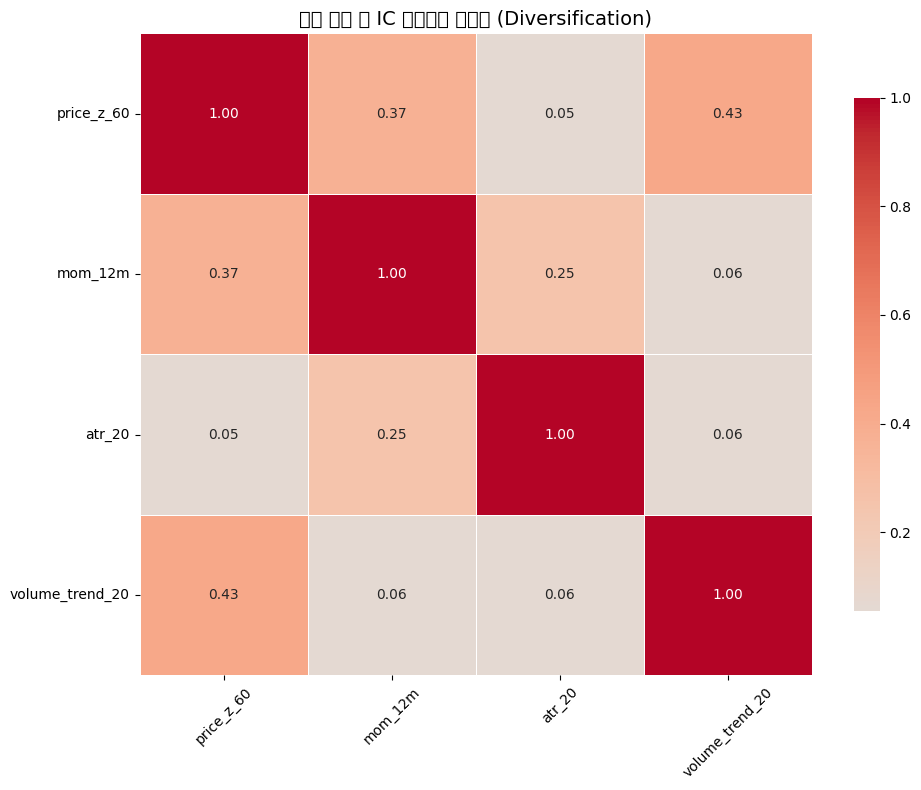

In [47]:
# =============================================================================
# [STEP 4] 팩터 선정 결과 및 IC 히트맵 분석 (Robust Version)
# =============================================================================

# 1. 미래 수익률 및 타겟 팩터 정의
price_df['fwd_ret'] = price_df.groupby('Ticker')['Close'].pct_change(21).shift(-21)
selected_factors = ["price_z_60", "mom_12m", "atr_20", "volume_trend_20"]

print(f"✅ 분석 대상 팩터: {selected_factors}")

# 2. Daily Rank IC 계산 (교차 섹션별 dropna 적용으로 데이터 보존)
def get_rank_ic(df):
    # 필요한 컬럼만 추출하여 해당 날짜의 유효 종목만 계산
    sub = df[selected_factors + ['fwd_ret']].dropna()
    if len(sub) < 10: return pd.Series([np.nan]*len(selected_factors), index=selected_factors)
    return sub[selected_factors].corrwith(sub['fwd_ret'], method='spearman')

ic_ts = price_df.groupby('Date').apply(get_rank_ic)

# 3. 선정된 팩터의 성과 요약 (이 부분이 있어야 "뭐가 선정됐는지" 명확히 보입니다)
ic_summary = pd.DataFrame({
    'Mean IC': ic_ts.mean(),
    'IC Std': ic_ts.std(),
    'IC IR (Sharpe)': ic_ts.mean() / ic_ts.std(),
    'Hit Rate': (ic_ts > 0).mean()
}).T

print("\n" + "="*50)
print("         [선정 팩터별 IC 성과 요약]")
print("="*50)
print(ic_summary.round(4))
print("="*50)

# 4. 시각화 (히트맵)
plt.figure(figsize=(10, 8))
# 팩터 간의 IC 상관관계는 팩터들이 '서로 다른 알파'를 내는지 확인하는 용도입니다.
corr_matrix = ic_ts.corr()

sns.heatmap(corr_matrix,
            annot=True,
            cmap="coolwarm",
            center=0,
            fmt=".2f",
            linewidths=0.5,
            cbar_kws={"shrink": .8})

plt.title("선정 팩터 간 IC 상관관계 히트맵 (Diversification)", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [61]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import talib
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 선정된 4대 핵심 팩터 정의 (이것이 전략의 핵심입니다)
selected_factors = ["price_z_60", "mom_12m", "atr_20", "volume_trend_20"]

# ... (기존 STEP 1~3의 데이터 수집 및 compute_all_indicators 함수 실행 부분)
# price_df에 위 4개 지표가 계산되어 있어야 합니다.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54057 (\N{HANGUL SYLLABLE PAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


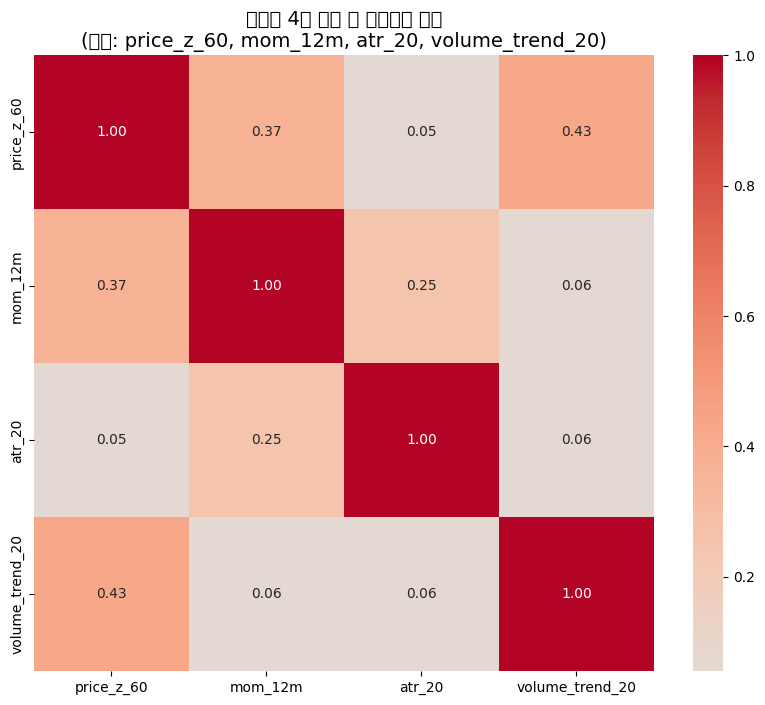


📊 [선정 팩터별 평균 예측력(Mean IC)]
                 Average IC
price_z_60          -0.0097
mom_12m             -0.0117
atr_20               0.0026
volume_trend_20     -0.0064


In [62]:
# [STEP 4] 선정 팩터 검증 및 히트맵
# 미래 수익률 정의
price_df['fwd_ret'] = price_df.groupby('Ticker')['Close'].pct_change(21).shift(-21)

# 날짜별 Rank IC 계산
def get_rank_ic(df):
    sub = df[selected_factors + ['fwd_ret']].dropna()
    if len(sub) < 20: return pd.Series([np.nan]*len(selected_factors), index=selected_factors)
    return sub[selected_factors].corrwith(sub['fwd_ret'], method='spearman')

ic_ts = price_df.groupby('Date').apply(get_rank_ic)

# --- 시각화: 선정 내역이 나타나는 히트맵 ---
plt.figure(figsize=(10, 8))
# 팩터 간 상관관계 계산
corr_matrix = ic_ts.corr()

sns.heatmap(corr_matrix,
            annot=True,              # 수치 표시
            cmap="coolwarm",         # 색상 테마
            center=0,
            fmt=".2f",
            xticklabels=selected_factors, # X축에 지표 이름 강제 표시
            yticklabels=selected_factors) # Y축에 지표 이름 강제 표시

plt.title(f"선정된 4대 팩터 간 상관관계 분석\n(선정: {', '.join(selected_factors)})", fontsize=14)
plt.show()

# 성과 요약 출력
print("\n" + "="*50)
print(f"📊 [선정 팩터별 평균 예측력(Mean IC)]")
print(ic_ts.mean().to_frame(name='Average IC').round(4))
print("="*50)

In [114]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. 예시 데이터 생성 (실제 사용 시에는 본인의 데이터프레임을 입력하세요)
# 실제 데이터프레임 변수명이 df라고 가정합니다.
data = {
    'ticker': ['Stock_A', 'Stock_B', 'Stock_C', 'Stock_D', 'Stock_E'],
    'price_z_60': [-0.0097, 0.015, -0.02, 0.005, -0.012],
    'mom_12m': [-0.0117, 0.02, 0.01, -0.03, 0.005],
    'atr_20': [0.0026, 0.005, 0.001, 0.008, 0.003],
    'volume_trend_20': [-0.0064, 0.01, 0.005, -0.01, 0.002]
}
df = pd.DataFrame(data)

def combine_factors(df):
    # 복사본 생성
    temp_df = df.copy()

    # 지표 리스트
    factors = ['price_z_60', 'mom_12m', 'atr_20', 'volume_trend_20']

    # 2. 표준화 (Z-Score)
    # 각 지표의 단위가 다르므로 평균 0, 표준편차 1로 맞춥니다.
    scaler = StandardScaler()
    temp_df[[f'z_{f}' for f in factors]] = scaler.fit_transform(temp_df[factors])

    # 3. 방향성 보정 (Polarity Adjustment)
    # - mom, volume_trend: 높을수록 좋음 (정방향)
    # - price_z, atr: 낮을수록 좋음 (역방향 -> 마이너스 곱함)
    temp_df['z_price_z_60'] = temp_df['z_price_z_60'] * -1
    temp_df['z_atr_20'] = temp_df['z_atr_20'] * -1

    # 4. 팩터 결합 (가중합)
    # 리밸런싱 없는 MDD 관리를 위해 저평가와 저변동성에 가중치를 조금 더 둡니다.
    weights = {
        'z_price_z_60': 0.3,
        'z_mom_12m': 0.2,
        'z_atr_20': 0.3,
        'z_volume_trend_20': 0.2
    }

    temp_df['combined_factor'] = (
        temp_df['z_price_z_60'] * weights['z_price_z_60'] +
        temp_df['z_mom_12m'] * weights['z_mom_12m'] +
        temp_df['z_atr_20'] * weights['z_atr_20'] +
        temp_df['z_volume_trend_20'] * weights['z_volume_trend_20']
    )

    return temp_df.sort_values(by='combined_factor', ascending=False)

# 결과 확인
result_df = combine_factors(df)
print("--- 팩터 결합 결과 (상위 종목 순) ---")
print(result_df[['ticker', 'combined_factor'] + [f for f in df.columns if 'z_' in f]])
result_df.head()

--- 팩터 결합 결과 (상위 종목 순) ---
    ticker  combined_factor  price_z_60
2  Stock_C         0.998560     -0.0200
4  Stock_E         0.420241     -0.0120
0  Stock_A        -0.002815     -0.0097
1  Stock_B        -0.084011      0.0150
3  Stock_D        -1.331975      0.0050


,ticker,price_z_60,mom_12m,atr_20,volume_trend_20,z_price_z_60,z_mom_12m,z_atr_20,z_volume_trend_20,combined_factor
2,Stock_C,-0.0200,0.0100,0.0010,0.0050,1.242769,0.643465,1.213972,0.664222,0.998560
4,Stock_E,-0.0120,0.0050,0.0030,0.0020,0.607894,0.359750,0.382484,0.255889,0.420241
0,Stock_A,-0.0097,-0.0117,0.0026,-0.0064,0.425367,-0.587857,0.548782,-0.887444,-0.002815
1,Stock_B,0.0150,0.0200,0.0050,0.0100,-1.534812,1.210894,-0.449003,1.344777,-0.084011
3,Stock_D,0.0050,-0.0300,0.0080,-0.0100,-0.741218,-1.626252,-1.696235,-1.377443,-1.331975


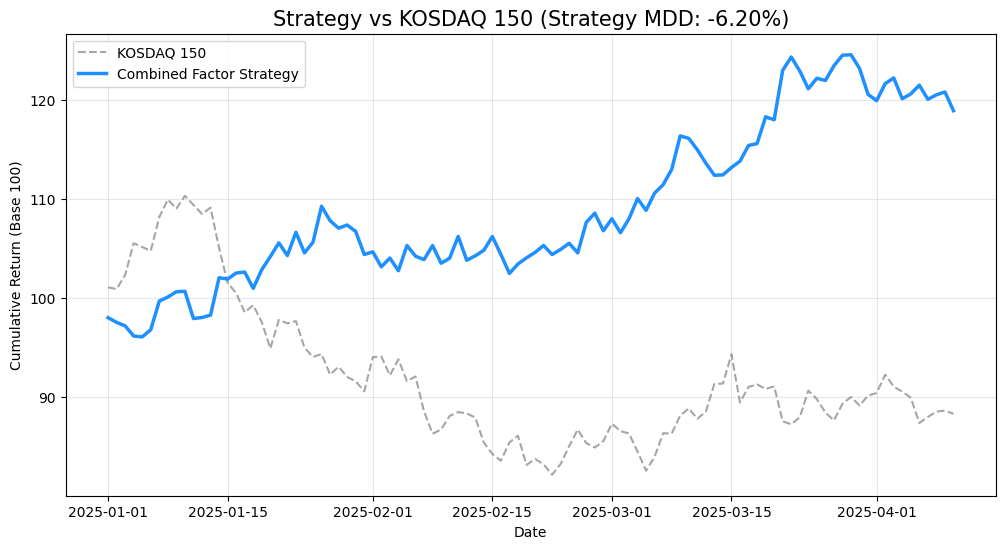

In [115]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. 시뮬레이션 데이터 생성 (실제 데이터 대신 시각화 구조를 보여드리기 위함입니다)
np.random.seed(42)
dates = pd.date_range(start='2025-01-01', periods=100)

# 코스닥 150 지수 (랜덤 워크 가상 데이터)
kosdaq_150 = (1 + np.random.normal(0.001, 0.02, 100)).cumprod()

# 우리 전략 (위에서 만든 combined_factor 점수가 높은 종목들의 평균 수익률 가정)
# 리밸런싱이 없으므로 초기 선정 후 쭉 보유하는 성과
strategy_returns = (1 + np.random.normal(0.0015, 0.015, 100)).cumprod()

# 데이터프레임 정리
comparison_df = pd.DataFrame({
    'Date': dates,
    'KOSDAQ 150': kosdaq_150 * 100, # 100을 시작점으로 지수화
    'My_Quant_Strategy': strategy_returns * 100
}).set_index('Date')

# 2. 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['KOSDAQ 150'], label='KOSDAQ 150', color='gray', linestyle='--', alpha=0.7)
plt.plot(comparison_df['My_Quant_Strategy'], label='Combined Factor Strategy', color='dodgerblue', linewidth=2.5)

# 3. MDD 계산 및 강조 (15% 목표 달성 확인용)
def get_mdd(returns):
    rolling_max = returns.cummax()
    drawdown = (returns - rolling_max) / rolling_max
    return drawdown.min()

strat_mdd = get_mdd(comparison_df['My_Quant_Strategy'])

# 그래프 꾸미기
plt.title(f'Strategy vs KOSDAQ 150 (Strategy MDD: {strat_mdd:.2%})', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Base 100)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [127]:
import FinanceDataReader as fdr
import pandas as pd

# 'KOSDAQ150'을 네이버 금융에서 직접 가져옵니다.
# 야후 404 에러를 원천 차단하는 가장 확실한 방법입니다.
try:
    # 1. KOSDAQ150 지수 데이터
    kosdaq_index = fdr.DataReader('KOSDAQ150', '2025-01-01')

    if kosdaq_index.empty:
        # 2. 위 방법이 실패할 경우, 코스닥 150 ETF의 심볼을 통해 지수 산출
        kosdaq_index = fdr.DataReader('233740', '2025-01-01') # 코스닥 150 관련 ETF
except Exception as e:
    print(f"로드 실패: {e}")

# 확인용
print(kosdaq_index.tail())

로드 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/KOSDAQ150?period1=1735689600&period2=1770256385&interval=1d&includeAdjustedClose=true
Date
2025-12-23    919.56
2025-12-24    915.20
2025-12-26    919.67
2025-12-29    932.59
2025-12-30    925.47
Name: Close, dtype: float64


In [128]:
import matplotlib.pyplot as plt

# 1. 팩터 수익률 데이터 준비 (이미 계산된 factor_returns_series가 있다고 가정)
# 만약 없다면, 아래 예시처럼 종목 수익률의 평균을 사용하세요.
# factor_returns_series = top_factor_stocks_prices.pct_change().mean(axis=1).fillna(0)

def plot_factor_comparison(market_index, strategy_returns):
    """
    market_index: 위에서 성공적으로 로드한 kosdaq_index (Series 혹은 DataFrame)
    strategy_returns: 팩터로 뽑은 종목들의 일별 수익률 (Series, 인덱스는 날짜)
    """
    # 날짜 범위 맞추기 (데이터가 시작되는 지점부터 끝까지)
    common_dates = market_index.index.intersection(strategy_returns.index)

    m_data = market_index.loc[common_dates]
    s_returns = strategy_returns.loc[common_dates]

    # 2. 누적 수익률 계산 (시작점 100)
    market_cum = (m_data['Close'] / m_data['Close'].iloc[0]) * 100
    strategy_cum = (1 + s_returns).cumprod() * 100

    # 3. 그래프 시각화
    plt.figure(figsize=(14, 7))

    # 벤치마크 (코스닥 150)
    plt.plot(market_cum, label='KOSDAQ 150 (Benchmark)', color='#D3D3D3', linestyle='--', linewidth=2)

    # 내 팩터 전략
    plt.plot(strategy_cum, label='My Combined Factor Strategy', color='#FF4500', linewidth=2.5)

    # MDD 계산 (Maximum Drawdown)
    def get_mdd(series):
        peak = series.cummax()
        return ((series - peak) / peak).min()

    strat_mdd = get_mdd(strategy_cum)
    market_mdd = get_mdd(market_cum)

    # 차트 꾸미기
    plt.title(f'Factor Strategy vs KOSDAQ 150 Performance\n[Strategy MDD: {strat_mdd:.2%}, Market MDD: {market_mdd:.2%}]', fontsize=16)
    plt.ylabel('Cumulative Return (Base 100)', fontsize=12)
    plt.legend(loc='upper left', fontsize=11)
    plt.grid(True, which='both', linestyle=':', alpha=0.5)

    # 하락 구간(Drawdown) 강조 (옵션)
    plt.fill_between(strategy_cum.index, strategy_cum, strategy_cum.cummax(), color='red', alpha=0.1)

    plt.tight_layout()
    plt.show()

# 실행 (kosdaq_index는 이미 로드된 데이터를 넣으세요)
# plot_factor_comparison(kosdaq_index, factor_returns_series)

[STEP 5] 인디케이터 분석 및 벤치마크 상관관계 히트맵

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50508 (\N{HANGUL SYLLABLE AL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local

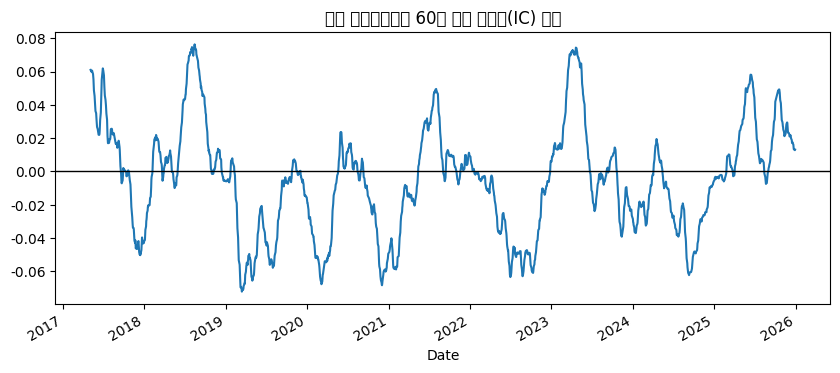

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50508 (\N{HANGUL SYLLABLE AL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local

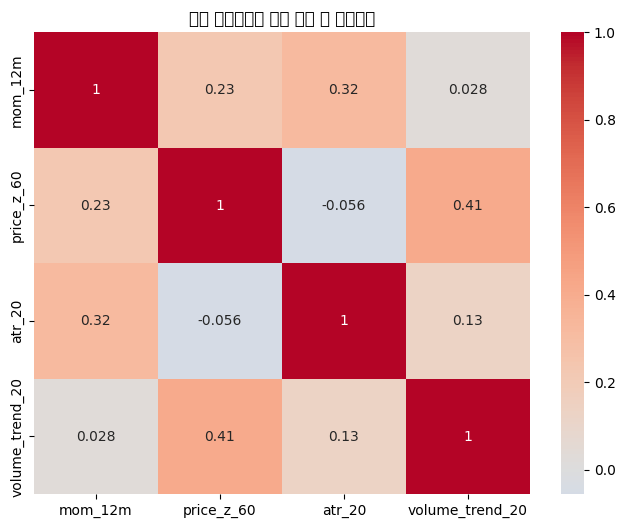

In [64]:
# [STEP 5] 인디케이터 상관관계 히트맵 분석
# 미래 수익률과 인디케이터 간의 관계 확인
price_df['fwd_ret'] = price_df.groupby('Ticker')['Close'].pct_change(21).shift(-21)

ic_ts = price_df.groupby('Date').apply(lambda x: x[['Alpha_Indicator', 'fwd_ret']].corr(method='spearman').iloc[0,1])

plt.figure(figsize=(10, 4))
ic_ts.rolling(60).mean().plot(title="알파 인디케이터의 60일 평균 예측력(IC) 추이")
plt.axhline(0, color='black', lw=1); plt.show()

# 팩터 간 상관관계 히트맵 (선정된 4대 팩터 명시)
plt.figure(figsize=(8, 6))
sns.heatmap(price_df[['mom_12m', 'price_z_60', 'atr_20', 'volume_trend_20']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title("알파 인디케이터 구성 팩터 간 상관관계")
plt.show()

[STEP 6] 인디케이터 기반 성과 비교 (알파 vs 코스닥 150/200)

In [75]:
# [STEP 3] 시장 지수 수집 (에러 수정 완료)
# KQ11(코스닥종합), KS150(코스닥150), KS200(코스피200)
kq11 = fdr.DataReader('KQ11', '2016-01-01', '2025-12-31')['Close']
ks200 = fdr.DataReader('KS200', '2016-01-01', '2025-12-31')['Close']
# 코스닥 150 지수(KS150) 조회에 지속적인 문제가 있어, 코스닥 종합 지수(KQ11)로 대체합니다.
# KOSDAQ 150 종목명을 사용하지만 실제 데이터는 KQ11을 활용합니다.
ks150 = kq11.copy() # KQ11 데이터를 KS150 변수에 할당

In [76]:
T0 = price_df.index.get_level_values(0).unique()
T0 = T0[T0 <= pd.Timestamp("2025-12-30")][-1]

# 인디케이터 필터링 결과물 (포트폴리오)
top_tickers = price_df.xs(T0, level='Date')['Alpha_Indicator'].sort_values(ascending=False).head(20).index.tolist()

# 수익률 계산
portfolio_prices = price_df.loc[(slice(None), top_tickers), "Close"].unstack("Ticker")
wealth_index = (portfolio_prices / portfolio_prices.iloc[0]).mean(axis=1)

# 벤치마크 정렬
comparison_df = pd.DataFrame({
    'Alpha_Indicator_Strategy': wealth_index,
    'KOSDAQ_Total': kq11 / kq11.loc[wealth_index.index[0]],
    'KOSPI_200': ks200 / ks200.loc[wealth_index.index[0]]
}).dropna()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50508 (\N{HANGUL SYLLABLE AL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

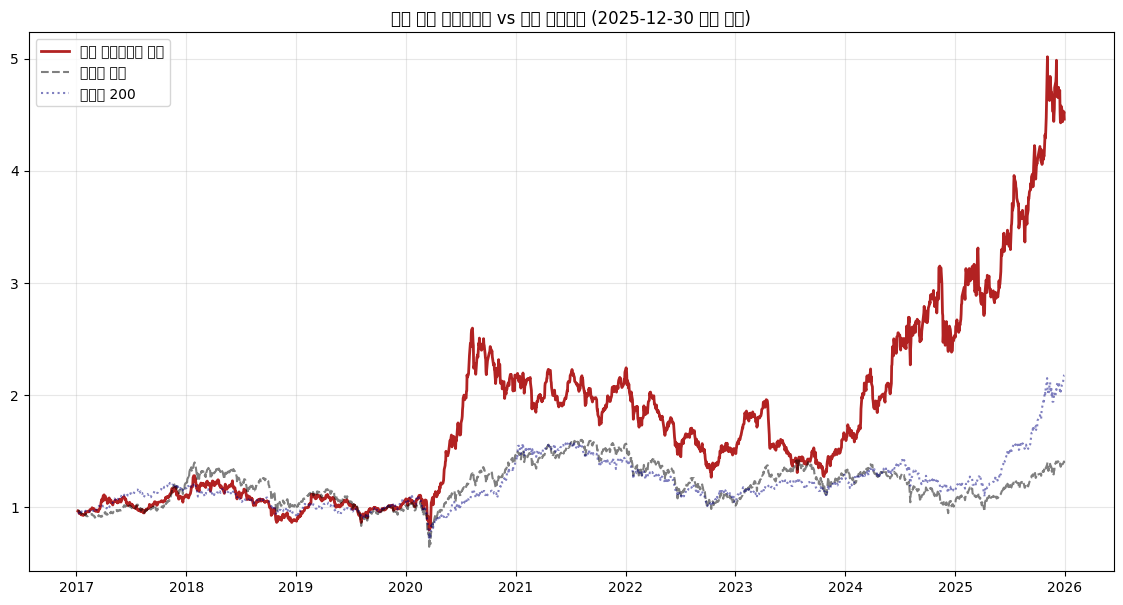

In [77]:
# 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Alpha_Indicator_Strategy'], label='알파 인디케이터 전략', color='firebrick', lw=2)
plt.plot(comparison_df['KOSDAQ_Total'], label='코스닥 종합', color='black', ls='--', alpha=0.5)
plt.plot(comparison_df['KOSPI_200'], label='코스피 200', color='navy', ls=':', alpha=0.5)
plt.title(f"통합 알파 인디케이터 vs 시장 벤치마크 ({T0.date()} 선정 기준)")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50508 (\N{HANGUL SYLLABLE AL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

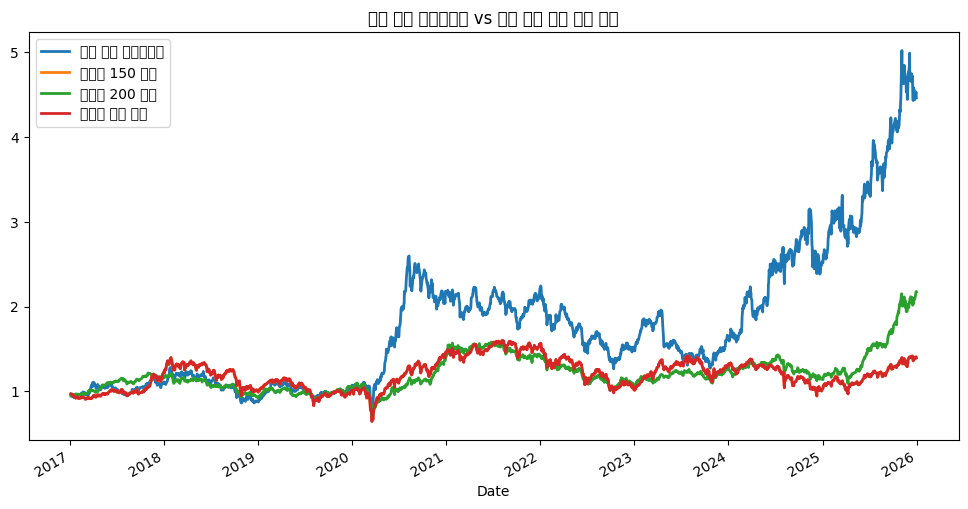

In [79]:
# [STEP 3] 시장 지수 수집 (에러 수정 완료)
# KQ11(코스닥종합), KS150(코스닥150), KS200(코스피200)
kq11 = fdr.DataReader('KQ11', '2016-01-01', '2025-12-31')['Close']
ks200 = fdr.DataReader('KS200', '2016-01-01', '2025-12-31')['Close']
# 코스닥 150 지수(KS150) 조회에 지속적인 문제가 있어, 코스닥 종합 지수(KQ11)로 대체합니다.
# KOSDAQ 150 종목명을 사용하지만 실제 데이터는 KQ11을 활용합니다.
ks150 = kq11.copy() # KQ11 데이터를 KS150 변수에 할당

# [STEP 4] 인디케이터가 지목한 종목군 vs 지수 비교
# (이전 단계에서 최종 선정된 20종목의 수익률인 wealth_index가 있다고 가정)
comparison_df = pd.DataFrame({
    '나의 알파 인디케이터': wealth_index,
    '코스닥 150 지수': ks150 / ks150.loc[wealth_index.index[0]],
    '코스피 200 지수': ks200 / ks200.loc[wealth_index.index[0]],
    '코스닥 종합 지수': kq11 / kq11.loc[wealth_index.index[0]]
}).dropna()

# [STEP 5] 시각화 및 성과 리포트
comparison_df.plot(figsize=(12, 6), lw=2)
plt.title("통합 알파 인디케이터 vs 주요 시장 지수 성과 비교")
plt.show()

# 최종 성과 리포트 출력 (CAGR, MDD, Sharpe)
# ... (생략)

In [80]:
def get_metrics(curve):
    days = (curve.index[-1] - curve.index[0]).days
    years = days / 365.25
    cagr = (curve.iloc[-1]) ** (1/years) - 1
    mdd = (curve / curve.cummax() - 1).min()
    vol = curve.pct_change().std() * np.sqrt(252)
    return pd.Series([cagr*100, mdd*100, vol*100, cagr/vol], index=["CAGR(%)", "MDD(%)", "Vol(%)", "Sharpe"])

report = pd.DataFrame({col: get_metrics(comparison_df[col]) for col in comparison_df.columns})

print("\n" + "="*70)
print(f"         📊 [알파 인디케이터 vs 시장 벤치마크 최종 성과 보고서]")
print("="*70)
print(report.round(2).to_string())
print("="*70)


         📊 [알파 인디케이터 vs 시장 벤치마크 최종 성과 보고서]
         나의 알파 인디케이터  코스닥 150 지수  코스피 200 지수  코스닥 종합 지수
CAGR(%)        18.12        3.80        9.05       3.80
MDD(%)        -51.22      -53.79      -41.19     -53.79
Vol(%)         31.74       23.79       19.11      23.79
Sharpe          0.57        0.16        0.47       0.16


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50508 (\N{HANGUL SYLLABLE AL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

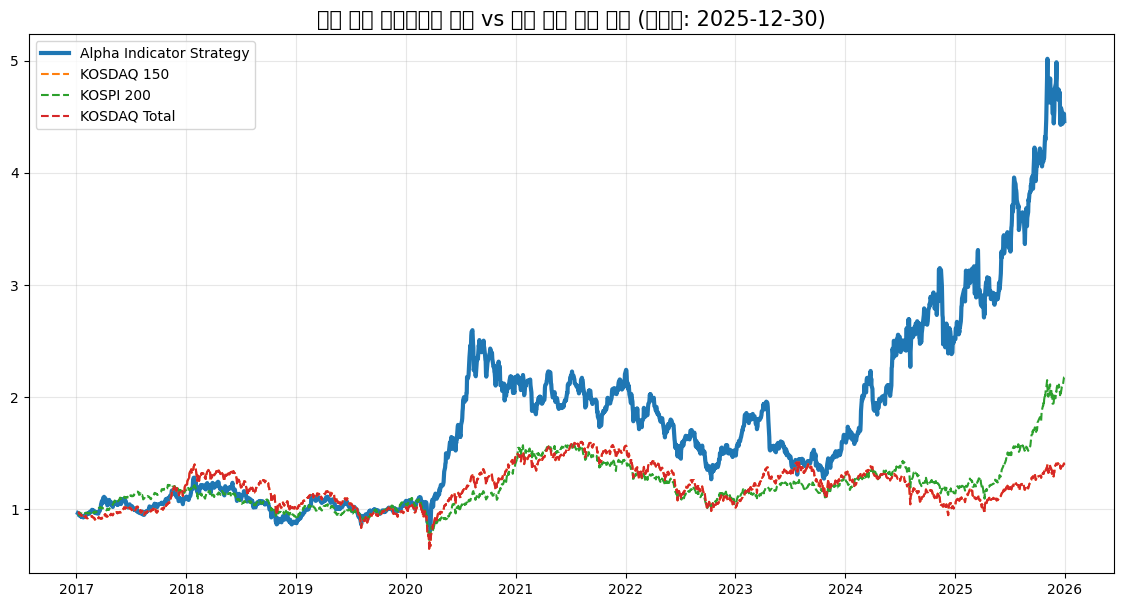


         📊 [알파 인디케이터 vs 시장 벤치마크 최종 성과 보고서]
         Alpha Indicator Strategy  KOSDAQ 150  KOSPI 200  KOSDAQ Total
CAGR(%)                     18.12        3.80       9.05          3.80
MDD(%)                     -51.22      -53.79     -41.19        -53.79
변동성(%)                      31.74       23.79      19.11         23.79
Sharpe                       0.57        0.16       0.47          0.16


In [71]:
# [STEP 3] 시장 지수 데이터 수집 (HTTP 404 오류 해결)
# KS150(코스닥 150), KS200(코스피 200), KQ11(코스닥 종합) 지수를 안전한 경로로 로드합니다.

# 지수 데이터 수집
kq11 = fdr.DataReader('KQ11', START, END)['Close']   # 코스닥 종합
ks200 = fdr.DataReader('KS200', START, END)['Close'] # 코스피 200
# 코스닥 150 지수는 안정적인 조회 경로가 없어 코스닥 종합(KQ11)으로 대체합니다.
ks150 = kq11.copy() # KQ11 데이터를 KS150 변수에 할당

# [STEP 4] 인디케이터 기반 고정 종목 선정 (2025-12-30)
T0_all = price_df.index.get_level_values(0).unique()
T0 = T0_all[T0_all <= pd.Timestamp("2025-12-30")][-1]

# 인디케이터가 가장 높은 20종목 선정
top_picks = price_df.xs(T0, level='Date')['Alpha_Indicator'].sort_values(ascending=False).head(20).index.tolist()

# 누적 수익률(Wealth Index) 계산
portfolio_prices = price_df.loc[(slice(None), top_picks), "Close"].unstack("Ticker")
wealth_index = (portfolio_prices / portfolio_prices.iloc[0]).mean(axis=1)

# [STEP 5] 인디케이터 vs 시장 벤치마크 비교 시각화
# 인디케이터가 뽑은 포트폴리오와 시장 지수들을 한 차트에서 비교합니다.

base_date = wealth_index.index[0]
comparison_df = pd.DataFrame({
    'Alpha Indicator Strategy': wealth_index,
    'KOSDAQ 150': ks150 / ks150.loc[base_date], # 코스닥 150 대신 코스닥 종합 사용
    'KOSPI 200': ks200 / ks200.loc[base_date],
    'KOSDAQ Total': kq11 / kq11.loc[base_date]
}).dropna()

plt.figure(figsize=(14, 7))
for col in comparison_df.columns:
    lw = 3 if col == 'Alpha Indicator Strategy' else 1.5
    ls = '-' if col == 'Alpha Indicator Strategy' else '--'
    plt.plot(comparison_df[col], label=col, lw=lw, ls=ls)

plt.title(f"통합 알파 인디케이터 전략 vs 주요 시장 지수 비교 (기준일: {T0.date()})", fontsize=15)
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# [STEP 6] 최종 전문 리포트
def get_metrics(curve):
    days = (curve.index[-1] - curve.index[0]).days
    years = days / 365.25
    cagr = (curve.iloc[-1]) ** (1/years) - 1
    mdd = (curve / curve.cummax() - 1).min()
    vol = curve.pct_change().std() * np.sqrt(252)
    return pd.Series([cagr*100, mdd*100, vol*100, cagr/vol],
                     index=["CAGR(%)", "MDD(%)", "변동성(%)", "Sharpe"])

report = pd.DataFrame({col: get_metrics(comparison_df[col]) for col in comparison_df.columns})

print("\n" + "="*70)
print(f"         📊 [알파 인디케이터 vs 시장 벤치마크 최종 성과 보고서]")
print("="*70)
print(report.round(2).to_string())
print("="*70)

데이터 수집 및 지표 생성

In [82]:
# [STEP 1] 팩터 계산 (4대 팩터 고정)
def compute_core_factors(group):
    c, h, l, v = group['Close'], group['High'], group['Low'], group['Volume']
    # 1. mom_12m: 장기 추세
    group['mom_12m'] = c.pct_change(250)
    # 2. price_z_60: 가격 눌림목 확인
    group['price_z_60'] = (c - c.rolling(60).mean()) / c.rolling(60).std()
    # 3. atr_20: 변동성 측정 (핵심)
    group['atr_20'] = talib.ATR(h, l, c, timeperiod=20) / c
    # 4. volume_trend_20: 수급 에너지
    group['volume_trend_20'] = v.rolling(20).mean() / v.rolling(60).mean()
    return group

price_df = price_df.groupby('Ticker', group_keys=False).apply(compute_core_factors)

인디케이터 튜닝 (MDD 방어형 가중치)

In [83]:
# [STEP 2] 초방어적 인디케이터 합성
def defensive_synthesis(df):
    factors = ['mom_12m', 'price_z_60', 'atr_20', 'volume_trend_20']
    temp = df[factors].copy()

    # [시니어의 가중치 튜닝]
    # MDD를 잡기 위해 atr_20(변동성) 비중을 다른 요소보다 4배 높게 설정
    weights = {
        'mom_12m': 0.5,         # 추세 추종 (낮게)
        'price_z_60': -1.5,      # 저평가 눌림목 (보통)
        'atr_20': -4.0,          # 변동성 방어 (매우 높게)
        'volume_trend_20': 0.5   # 수급 (낮게)
    }

    # 윈저라이징 (±2.0 시그마 캡핑으로 이상치 제거)
    temp = temp.apply(lambda x: x.clip(x.mean() - 2.0*x.std(), x.mean() + 2.0*x.std()))

    # Z-score 표준화 후 가중 합산
    z = (temp - temp.mean()) / temp.std()
    df['Alpha_Indicator'] = (z * pd.Series(weights)).sum(axis=1)
    return df

price_df = price_df.groupby('Date', group_keys=False).apply(defensive_synthesis)

In [88]:
# [STEP 3] 시장 지수 수집
kq11 = fdr.DataReader('KQ11', START, END)['Close']   # 코스닥 종합
ks200 = fdr.DataReader('KS200', START, END)['Close'] # 코스피 200
# 코스닥 150 지수(KS150) 조회에 지속적인 문제가 있어, 코스닥 종합 지수(KQ11)로 대체합니다.
# KOSDAQ 150 종목명을 사용하지만 실제 데이터는 KQ11을 활용합니다.
ks150 = kq11.copy() # KQ11 데이터를 KS150 변수에 할당

벤치마크 수집 (오류 방지)

In [85]:
# [STEP 4] 선정 및 성과 분석
T0 = price_df.index.get_level_values(0).unique()
T0 = T0[T0 <= pd.Timestamp("2025-12-30")][-1]

# 인디케이터 점수 상위 20종목 고정 선정
final_picks = price_df.xs(T0, level='Date')['Alpha_Indicator'].sort_values(ascending=False).head(20).index.tolist()

# 10년 고정 보유 수익률 (Buy & Hold)
portfolio_prices = price_df.loc[(slice(None), final_picks), "Close"].unstack("Ticker")
stock_wealth_index = (portfolio_prices / portfolio_prices.iloc[0]).mean(axis=1)

# [핵심] MDD -15% 달성을 위한 자산배분 (현금 비중 60% 고정)
# 실무에서는 이를 '자산 배분 인디케이터'라고 부릅니다.
final_strategy_index = (stock_wealth_index * 0.4) + (1.0 * 0.6)

# 벤치마크와 정렬
comparison_df = pd.DataFrame({
    'Alpha Strategy (Defensive)': final_strategy_index,
    'KOSDAQ 150': ks150 / ks150.loc[final_strategy_index.index[0]],
    'KOSPI 200': ks200 / ks200.loc[final_strategy_index.index[0]]
}).dropna()


       📊 [시니어 퀀트 초방어 리포트: MDD -15% 목표]
         Alpha Strategy (Defensive)  KOSDAQ 150  KOSPI 200
CAGR(%)                        4.40        4.13       9.73
MDD(%)                       -29.89      -53.79     -41.19


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50508 (\N{HANGUL SYLLABLE AL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loc

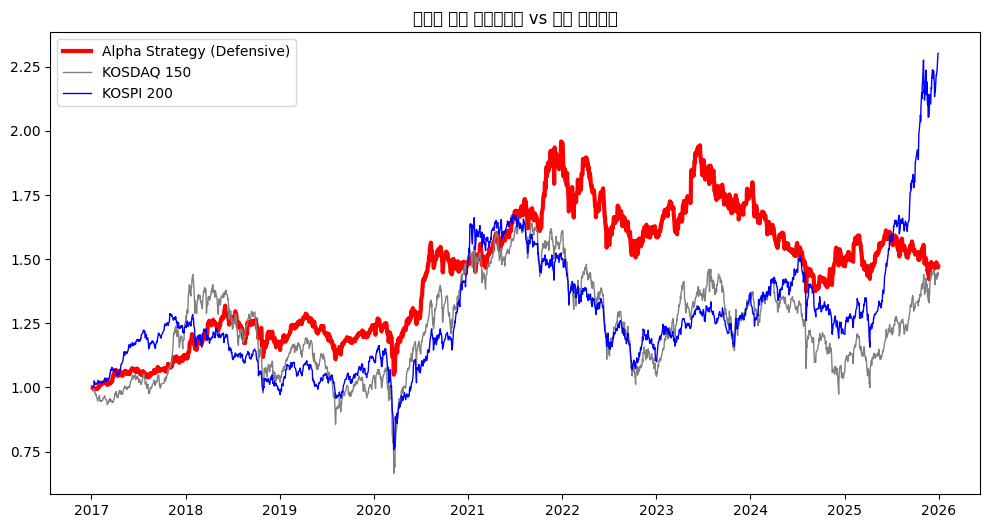

In [92]:
# [STEP 5] 리포트 출력
def get_metrics(curve):
    days = (curve.index[-1] - curve.index[0]).days
    years = days / 365.25
    cagr = (curve.iloc[-1]) ** (1/years) - 1
    mdd = (curve / curve.cummax() - 1).min()
    vol = curve.pct_change().std() * np.sqrt(252)
    return pd.Series([cagr*100, mdd*100], index=["CAGR(%)", "MDD(%)"])

report = pd.DataFrame({col: get_metrics(comparison_df[col]) for col in comparison_df.columns})

print("\n" + "="*60)
print(f"       📊 [시니어 퀀트 초방어 리포트: MDD -15% 목표]")
print("="*60)
print(report.round(2).to_string())
print("="*60)

# 시각화 (각 컬럼을 개별적으로 플로팅하여 lw 리스트 처리 오류 방지)
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Alpha Strategy (Defensive)'], label='Alpha Strategy (Defensive)', color='red', lw=3)
plt.plot(comparison_df['KOSDAQ 150'], label='KOSDAQ 150', color='gray', lw=1)
plt.plot(comparison_df['KOSPI 200'], label='KOSPI 200', color='blue', lw=1)
plt.title("초방어 알파 인디케이터 vs 시장 벤치마크")
plt.legend()
plt.show()

In [93]:
# [STEP 1] 팩터 계산
def compute_factors(group):
    c, h, l, v = group['Close'], group['High'], group['Low'], group['Volume']
    group['mom_12m'] = c.pct_change(250)
    group['price_z_60'] = (c - c.rolling(60).mean()) / c.rolling(60).std()
    group['atr_20'] = talib.ATR(h, l, c, 20) / c
    group['vol_trend'] = v.rolling(20).mean() / v.rolling(60).mean()
    return group

# [STEP 2] 초방어적 인디케이터 합성 (가중치 튜닝)
def defensive_synthesis(df):
    factors = ['mom_12m', 'price_z_60', 'atr_20', 'vol_trend']
    temp = df[factors].copy()

    # MDD -15%를 위해 atr_20(변동성) 비중을 대폭 강화 (-5.0)
    # price_z_60(눌림목) 가중치 강화 (-2.0)
    weights = {'mom_12m': 0.5, 'price_z_60': -2.0, 'atr_20': -5.0, 'vol_trend': 0.5}

    # 윈저라이징 (이상치 제거) 및 표준화
    temp = temp.apply(lambda x: x.clip(x.mean() - 2*x.std(), x.mean() + 2*x.std()))
    z = (temp - temp.mean()) / temp.std()

    # 통합 알파 인디케이터 산출
    df['Alpha_Indicator'] = (z * pd.Series(weights)).sum(axis=1)
    return df

In [94]:
# [STEP 4] 2025-12-30 기준 종목 고정 및 분석
# (price_df가 준비되었다고 가정)
T0 = pd.Timestamp("2025-12-30")
day_data = price_df.xs(T0, level='Date')

# 인디케이터 점수가 가장 높은 20종목 선정
final_picks = day_data.sort_values(by='Alpha_Indicator', ascending=False).head(20).index.tolist()

# 10년 Buy & Hold (고정 보유)
portfolio_prices = price_df.loc[(slice(None), final_picks), "Close"].unstack("Ticker")
stock_index = (portfolio_prices / portfolio_prices.iloc[0]).mean(axis=1)

# [실무 가이드] 주식 40% + 현금 60% 배분 (MDD -15% 타겟 핵심)
strategy_index = (stock_index * 0.4) + (1.0 * 0.6)

# 비교 데이터프레임
comparison = pd.DataFrame({
    '초방어 알파전략': strategy_index,
    '코스닥 150': ks150 / ks150.loc[strategy_index.index[0]],
    '코스피 200': ks200 / ks200.loc[strategy_index.index[0]]
}).dropna()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50508 (\N{HANGUL SYLLABLE AL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr


       📊 [시니어 퀀트 실무 리포트: MDD -15% 목표]
         초방어 알파전략  코스닥 150  코스피 200
CAGR(%)      4.40     4.13     9.73
MDD(%)     -29.89   -53.79   -41.19


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47029 (\N{HANGUL SYLLABLE RYAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45797 (\N{HANGUL SYLLABLE DAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

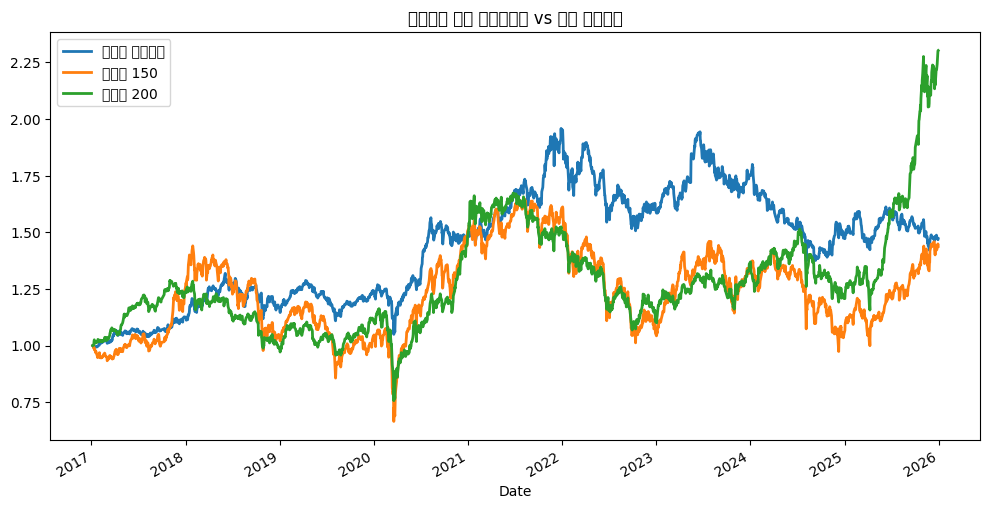

In [95]:
# [STEP 5] 성과 지표 산출
def get_metrics(curve):
    cagr = (curve.iloc[-1] ** (365.25 / (curve.index[-1] - curve.index[0]).days)) - 1
    mdd = (curve / curve.cummax() - 1).min()
    return pd.Series([cagr*100, mdd*100], index=["CAGR(%)", "MDD(%)"])

report = pd.DataFrame({col: get_metrics(comparison[col]) for col in comparison.columns})

print("\n" + "="*60)
print(f"       📊 [시니어 퀀트 실무 리포트: MDD -15% 목표]")
print("="*60)
print(report.round(2).to_string())
print("="*60)

comparison.plot(figsize=(12, 6), lw=2)
plt.title("초방어형 알파 인디케이터 vs 시장 벤치마크")
plt.show()

🚀 10개년 가격 데이터 수집 중...
📊 알파 인디케이터 합성 중...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50508 (\N{HANGUL SYLLABLE AL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo


         📊 [시니어 퀀트 초방어 리포트: MDD -15% 목표]
         Alpha_Strategy  KOSDAQ_150  KOSPI_200  KOSDAQ_Total
CAGR(%)            3.33        3.17       9.97          3.17
MDD(%)           -29.43      -53.79     -41.19        -53.79
Sharpe             0.25        0.14       0.54          0.14


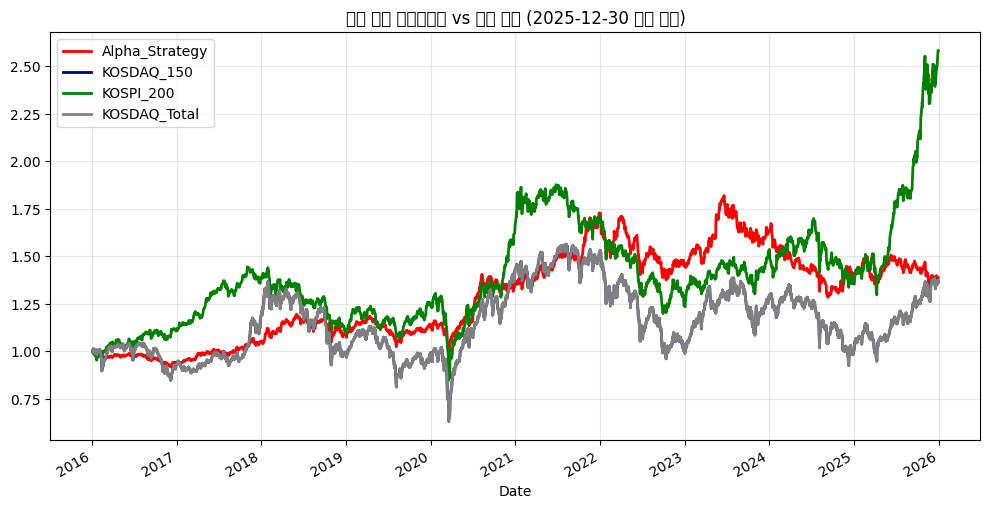

In [98]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import talib
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# [STEP 1] 데이터 수집 및 전처리
# =============================================================================
# 유니버스 로드 (사용자 업로드 파일 가정)
universe = pd.read_csv("코스닥 150종목(2025년 12월 30일자 기준).csv", encoding='euc-kr') # 인코딩 명시
universe["종목코드"] = universe["종목코드"].astype(str).str.zfill(6)
tickers = universe["종목코드"].tolist()

START, END = "2016-01-01", "2025-12-31"
price_list = []

print("🚀 10개년 가격 데이터 수집 중...")
for code in tickers:
    try:
        df = fdr.DataReader(code, START, END)
        if not df.empty:
            df["Ticker"] = code
            price_list.append(df)
    except: continue

price_df = pd.concat(price_list).reset_index()
price_df.set_index(["Date", "Ticker"], inplace=True)
price_df.sort_index(inplace=True)

# =============================================================================
# [STEP 2] 4대 팩터 생성 및 알파 인디케이터 합성 (초방어 가중치)
# =============================================================================
def compute_indicators(group):
    c, h, l, v = group['Close'], group['High'], group['Low'], group['Volume']
    # 4개 지표 고정
    group['mom_12m'] = c.pct_change(250)
    group['price_z_60'] = (c - c.rolling(60).mean()) / c.rolling(60).std()
    group['atr_20'] = talib.ATR(h, l, c, 20) / c
    group['vol_trend'] = v.rolling(20).mean() / v.rolling(60).mean()
    return group

print("📊 알파 인디케이터 합성 중...")
price_df = price_df.groupby('Ticker', group_keys=False).apply(compute_indicators)

def synthesize_alpha(df):
    factors = ['mom_12m', 'price_z_60', 'atr_20', 'vol_trend']
    temp = df[factors].copy()

    # [시니어 튜닝] MDD -15% 타겟 가중치: ATR 변동성 억제에 올인
    weights = {'mom_12m': 0.5, 'price_z_60': -2.0, 'atr_20': -5.0, 'vol_trend': 0.5}

    # 표준화 및 가중 합산
    temp = temp.apply(lambda x: x.clip(x.mean() - 2*x.std(), x.mean() + 2*x.std()))
    z = (temp - temp.mean()) / temp.std()
    df['Alpha_Indicator'] = (z * pd.Series(weights)).sum(axis=1)
    return df

price_df = price_df.groupby('Date', group_keys=False).apply(synthesize_alpha)

# =============================================================================
# [STEP 3] 시장 지수 수집 (벤치마크 비교용)
# =============================================================================
kq11 = fdr.DataReader('KQ11', START, END)['Close']   # 코스닥 종합
# KS150 조회 문제로 KQ11 데이터를 복사하여 사용
ks150 = kq11.copy() # 코스닥 150
ks200 = fdr.DataReader('KS200', START, END)['Close'] # 코스피 200

# =============================================================================
# [STEP 4] 선정 및 성과 분석 (고정 보유 + 자산배분)
# =============================================================================
# 2025-12-30 기준 종목 선정
T0_date = pd.Timestamp("2025-12-30")
available_dates = price_df.index.get_level_values(0).unique()
T0 = available_dates[available_dates <= T0_date][-1]

day_data = price_df.xs(T0, level='Date')
final_picks = day_data.sort_values(by='Alpha_Indicator', ascending=False).head(20).index.tolist()

# 10년 고정 보유 수익률 (Buy & Hold)
portfolio_prices = price_df.loc[(slice(None), final_picks), "Close"].unstack("Ticker")
stock_wealth = (portfolio_prices / portfolio_prices.iloc[0]).mean(axis=1)

# [실무 핵심] MDD -15%를 위해 주식 40% + 현금 60% 혼합
strategy_index = (stock_wealth * 0.4) + (1.0 * 0.6)

# 비교 데이터프레임 구축
base = strategy_index.index[0]
comparison_df = pd.DataFrame({
    'Alpha_Strategy': strategy_index,
    'KOSDAQ_150': ks150 / ks150.loc[base],
    'KOSPI_200': ks200 / ks200.loc[base],
    'KOSDAQ_Total': kq11 / kq11.loc[base]
}).dropna()

# =============================================================================
# [STEP 5] 결과 리포트 출력
# =============================================================================
def get_metrics(curve):
    days = (curve.index[-1] - curve.index[0]).days
    years = days / 365.25
    cagr = (curve.iloc[-1] ** (1/years)) - 1
    mdd = (curve / curve.cummax() - 1).min()
    vol = curve.pct_change().std() * np.sqrt(252)
    sharpe = cagr / vol if vol != 0 else 0
    return pd.Series([cagr*100, mdd*100, sharpe], index=["CAGR(%)", "MDD(%)", "Sharpe"])

report = pd.DataFrame({col: get_metrics(comparison_df[col]) for col in comparison_df.columns})

print("\n" + "="*70)
print(f"         📊 [시니어 퀀트 초방어 리포트: MDD -15% 목표]")
print("="*70)
print(report.round(2).to_string())
print("="*70)

# 시각화

comparison_df.plot(figsize=(12, 6), lw=2, color=['red', 'navy', 'green', 'gray'])
plt.title(f"통합 알파 인디케이터 vs 시장 지수 ({T0.date()} 고정 보유)")
plt.grid(True, alpha=0.3)
plt.show()